In [102]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import ImageGrid


In [103]:
directory = 'D:\generate human fake face face project\code\img_align_celeba\images'

# get all images from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=directory,color_mode='rgb',batch_size=128,image_size=(32,32),label_mode=None,shuffle=True,seed=42)
# Normalize the data
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)
# dataset = dataset.map(lambda x: x/255.00)

Found 202599 files.


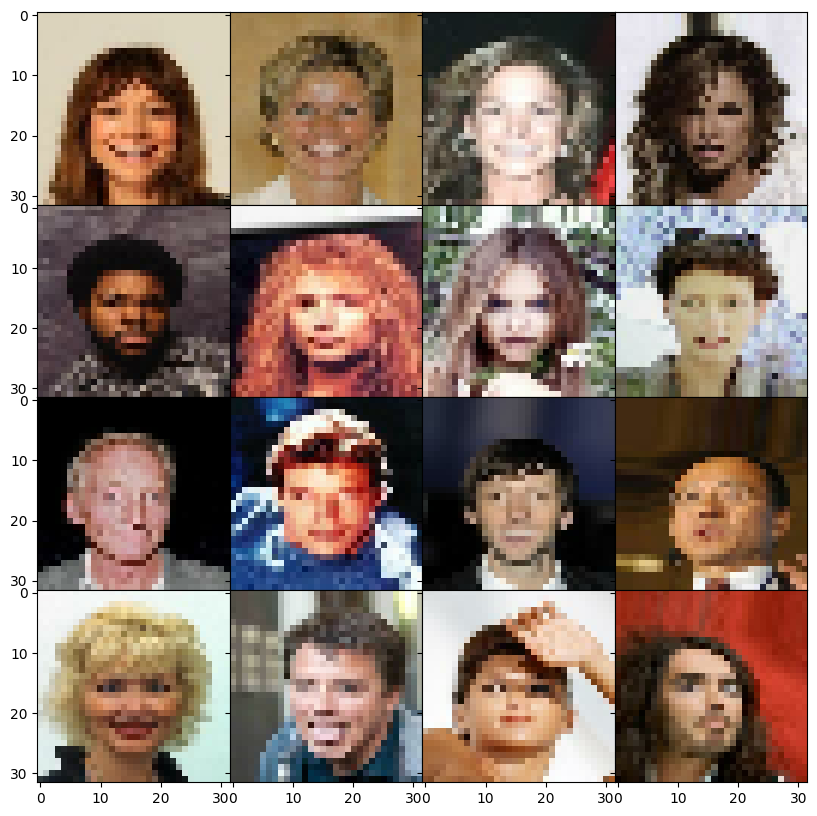

In [112]:
# Grid of Images
it =iter(dataset)
one_batch = next(it).numpy()
one_batch = (one_batch + 1) / 2.0
images=one_batch[:32,:,:,:]

# show the images
fig = plt.figure(figsize=(10,10))
grid=ImageGrid(fig,111,nrows_ncols=(4,4),axes_pad=0)

for ax,im in zip(grid,images):
    ax.imshow(im)
plt.show()

# GANs => Generative Adversarial network
- it has two thing Generator and Discriminator
- Generator generates the fake images
- Discriminator is used to identify which one is real and which one is real image (just like Image classification task)

In [105]:
from tensorflow.keras.layers import Conv2D,LeakyReLU,BatchNormalization,Dropout,Flatten,Dense,Activation,Reshape
from tensorflow.keras import Model,Input

In [106]:
def discriminator_model():
    disc_input = Input(shape=(32,32,3),name='discriminator_network')
    x=Conv2D(filters=64,kernel_size=3,strides = (2,2),padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    x=Conv2D(filters=128,kernel_size=3,strides = (2,2),padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    x=Conv2D(filters=128,kernel_size=3,strides = (2,2),padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    x=Conv2D(filters=64,kernel_size=3,strides = (2,2),padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Flatten()(x)
    x=Dense(1)(x)

    output = Activation('sigmoid')(x)
    disc =Model(inputs=disc_input,outputs=output)
    return disc







In [107]:
from tensorflow.keras.layers import Conv2D,LeakyReLU,BatchNormalization,Dropout,Flatten,Dense,Activation,Reshape,Conv2DTranspose
from tensorflow.keras import Model,Input
def generator_model(z_dim=100):
    gen_input=Input(shape=(z_dim,),name='generator_network')
    x=Dense(8*8*3)(gen_input)
    x=Reshape(target_shape=(8,8,3))(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)

    x=Conv2DTranspose(filters=512,kernel_size=3,strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=Conv2DTranspose(filters=256,kernel_size=3,strides=(2,2),padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=Conv2DTranspose(filters=158,kernel_size=3,strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=Conv2DTranspose(filters=128,kernel_size=3,strides=(2,2),padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)

    x=Conv2DTranspose(filters=64,kernel_size=3,strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)

    x=Conv2DTranspose(filters=3,kernel_size=3,strides=(1,1),padding='same',activation='tanh')(x)
    fake_images_gen=LeakyReLU()(x)

    model_gen =Model(inputs=gen_input,outputs=fake_images_gen)
    return model_gen











In [108]:
disc_model = discriminator_model()
gen_model = generator_model()

# Compile the model that trains discriminator

disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [109]:
# compile the model that train generator.
z_dim=100
disc_model.trainable=False
model_input=Input(shape=(z_dim,),name='model input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input,model_output)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])










In [110]:
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_12 (Functional)      │ (None, 32, 32, 3)      │     1,839,973 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 1)              │       297,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,137,254 (8.15 MB)

 Trainable params: 1,837,731 (7.01 MB)

 Non-trainable params: 299,523 (1.14 MB)

In [113]:
def train_discriminator(batch,batch_size):
    valid = np.ones((batch_size,1))
    fake = np.ones((batch_size,1))
    disc_model.train_on_batch(batch,valid)
    noise = np.random.normal(0,1,(batch_size,z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image,fake)


def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0,1,(batch_size,z_dim))
    model.train_on_batch(noise,valid)

In [114]:
def save_images(fake_image,path):
    image=tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path,image)
    return image

def generate_and_save_image(path):
    noise = np.random.normal(0,1,(1,z_dim))
    fake_image=gen_model(noise)
    image=save_images(fake_image[0], path)
    plt.imshow(image)
    plt.show()



No. of epoches -> 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Batch Images -> 0


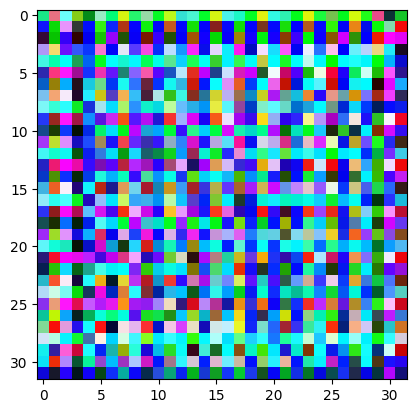

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━

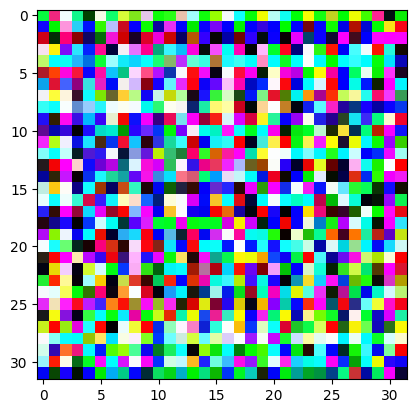

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

KeyboardInterrupt: 

In [118]:
import os

output_dir = r"D:\generate human fake face face project\code\fake images"
os.makedirs(output_dir, exist_ok=True)

for epochs in range(20):
    print(f'No. of epoches -> {epochs}')
    for i, batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])

        if i % 100 == 0:
            print(f"Batch Images -> {i}")
            filename = f"epochs{epochs}_batch_{i}.jpg"
            filepath = os.path.join(output_dir, filename)
            generate_and_save_image(path=filepath)
